# Statistics review 10: Further nonparametric methods

R code accompanying [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC420045/pdf/cc2836.pdf)

## Key learning points

- Nonparametric methods for testing differences between more than two groups or treatments

In [14]:
suppressPackageStartupMessages(library(tidyverse))

In [15]:
options(repr.plot.width=4, repr.plot.height=3)

## Kruskal–Wallis test

Nonparametric alternative to one-way analysis of variance.

### Manual calculation

In [68]:
ct <- c(7,1,2,6,11,8)
m <- c(4,7,16,11,21)
ns <- c(20,25,13,9,14,11)

In [69]:
icu <- c(rep("ct", length(ct)), rep("m", length(m)), rep("ns", length(ns)))
days <- c(ct, m, ns)

df <- data.frame(icu=icu, days=days)

In [70]:
head(df)

icu,days
ct,7
ct,1
ct,2
ct,6
ct,11
ct,8


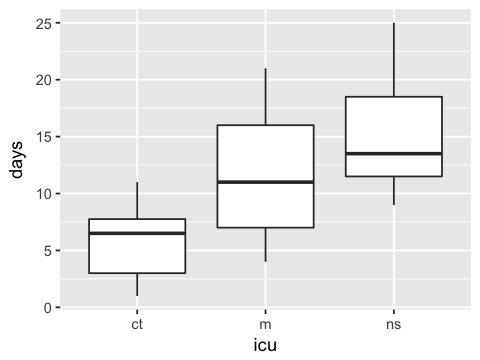

In [71]:
ggplot(df, aes(x=icu, y=days)) + geom_boxplot()

In [37]:
df1 <- df %>% mutate(rank=rank(days))
head(df1)

icu,days,rank
ct,7,5.5
ct,1,1.0
ct,2,2.0
ct,6,4.0
ct,11,10.0
ct,8,7.0


In [42]:
df2 <- df1 %>% group_by(icu) %>% summarize(r = sum(rank), n=n())
df2

icu,r,n
ct,29.5,6
m,48.5,5
ns,75.0,6


In [57]:
N <- dim(df1)[1]

T <- (12/(N*(N+1)))*sum((df2$r^2/df2$n)) - 3*(N+1)

In [58]:
round(T, 2)

[1] 6.9

In [59]:
df <- dim(df2)[1]- 1
df

[1] 2

In [60]:
round(1 - pchisq(T, df), 4)

[1] 0.0317

### Using built in function

In [61]:
kruskal.test(days ~ icu, data=df1)


	Kruskal-Wallis rank sum test

data:  days by icu
Kruskal-Wallis chi-squared = 6.9442, df = 2, p-value = 0.03105


### Dunn test for multiple comparisons

In [63]:
suppressPackageStartupMessages(library(FSA))

In [65]:
dunnTest(df1$days, df1$icu)

Dunn (1964) Kruskal-Wallis multiple comparison
  p-values adjusted with the Holm method.



  Comparison          Z    P.unadj      P.adj
1     ct - m -1.5691321 0.11661717 0.23323435
2    ct - ns -2.6090676 0.00907893 0.02723679
3     m - ns -0.9185163 0.35834862 0.35834862

### Ad-hoc comparisons with Wilcoxon

In [73]:
pairwise.wilcox.test(df1$days, df1$icu, p.adjust.method = "holm")

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”


	Pairwise comparisons using Wilcoxon rank sum test 

data:  df1$days and df1$icu 

   ct    m    
m  0.338 -    
ns 0.031 0.464

P value adjustment method: holm 

## The Jonckheere–Terpstra test

For comparisons where the treatment group is ordinal.

We re-use the same data set, assuming that the ICU ordering is ct, m, ns.

### Using a package

In [92]:
head(df1)

icu,days,rank
ct,7,5.5
ct,1,1.0
ct,2,2.0
ct,6,4.0
ct,11,10.0
ct,8,7.0


In [94]:
df1$icu <- factor(df1$icu, levels=c("ct", "m","ns"))

In [95]:
str(df1)

'data.frame':	17 obs. of  3 variables:
 $ icu : Factor w/ 3 levels "ct","m","ns": 1 1 1 1 1 1 2 2 2 2 ...
 $ days: num  7 1 2 6 11 8 4 7 16 11 ...
 $ rank: num  5.5 1 2 4 10 7 3 5.5 14 10 ...


In [74]:
library(clinfun)

In [91]:
jonckheere.test(df1$days, as.numeric(df1$icu), nperm=10000)


	Jonckheere-Terpstra test

data:  
JT = 77, p-value = 0.0102
alternative hypothesis: two.sided


In [85]:
df1$days

[1]  7  1  2  6 11  8  4  7 16 11 21 20 25 13  9 14 11

In [89]:
as.numeric(df1$icu)

[1] 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3

## The Friedman Test

Extension of the sign test for matched pairs and is used when the data arise from more than two related samples. The Friedman test is the non-parametric alternative to the one-way ANOVA with repeated measures. Used as a two-way ANOVA with a completely balanced design.

In [196]:
A <- c(6,9,10,14,11)
B <- c(9,16,14,14,16)
C <- c(10,16,22,40,17)
D <- c(16,32,67,19,60)

df3 <- data.frame(Patient = 1:5, A=A, B=B, C=C, D=D)

In [197]:
df3.rank <- t(apply(df3[,2:5], 1, rank))
df3.rank <- data.frame(df3.rank)
df3.rank

A,B,C,D
1.0,2.0,3.0,4
1.0,2.5,2.5,4
1.0,2.0,3.0,4
1.5,1.5,4.0,3
1.0,2.0,3.0,4


In [198]:
df4 <- df3.rank %>% summarise_each("sum")
df4

A,B,C,D
5.5,10,15.5,19


In [199]:
k <- dim(df3.rank)[2] 
b <- dim(df3.rank)[1]

T <- (12/(b*k*(k+1)))*sum(df4^2) - 3*b*(k+1)

In [200]:
T

[1] 12.78

In [201]:
round(1 - pchisq(T, k-1), 4)

[1] 0.0051

In [202]:
df3

Patient,A,B,C,D
1,6,9,10,16
2,9,16,16,32
3,10,14,22,67
4,14,14,40,19
5,11,16,17,60


In [203]:
df5 <- df3 %>% gather(treatment, score, A:D)
head(df5)

Patient,treatment,score
1,A,6
2,A,9
3,A,10
4,A,14
5,A,11
1,B,9


In [204]:
str(df5)

'data.frame':	20 obs. of  3 variables:
 $ Patient  : int  1 2 3 4 5 1 2 3 4 5 ...
 $ treatment: chr  "A" "A" "A" "A" ...
 $ score    : num  6 9 10 14 11 9 16 14 14 16 ...


#### First way  to call Friedman test

In [206]:
friedman.test(score ~ treatment | Patient, data=df5)


	Friedman rank sum test

data:  score and treatment and Patient
Friedman chi-squared = 13.312, df = 3, p-value = 0.004007


#### Second way to call Friedman test

In [209]:
friedman.test(df5$score, df5$treatment, df5$Patient)


	Friedman rank sum test

data:  df5$score, df5$treatment and df5$Patient
Friedman chi-squared = 13.312, df = 3, p-value = 0.004007


In [1]:
head(chickwts)

weight,feed
179,horsebean
160,horsebean
136,horsebean
227,horsebean
217,horsebean
168,horsebean


## Exercise

**1**. Practice using the non-parametric tests on the `chickwts` data set.